In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

In [2]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]= "true"
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [3]:
data_dir = "D:\\Data\\cell_images"
os.listdir(data_dir)

train_path = data_dir+"\\train\\"
test_path = data_dir+"\\test\\"

os.listdir(train_path)
os.listdir(test_path)

['parasitized', 'uninfected']

In [4]:

os.listdir(train_path+"uninfected")[1]

un_cell = train_path+"uninfected\\"+"C100P61ThinF_IMG_20150918_144104_cell_131.png"

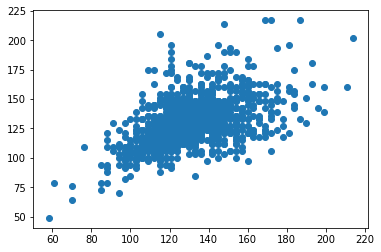

In [5]:

dim1=[]
dim2=[]

for image_filename in os.listdir(test_path+"\\uninfected"):
    img = imread(test_path+"uninfected\\"+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)
    
plt.scatter(x=dim1, y=dim2)    

np.mean(dim1)
np.mean(dim2)    

image_shape = (131, 131, 3)


In [6]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#help(ImageDataGenerator())

image_gen = ImageDataGenerator(rotation_range=360,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range = 0.1,
                               horizontal_flip=True,
                               fill_mode="nearest"
                               )

image_gen.flow_from_directory(train_path)
image_gen.flow_from_directory(test_path)


Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [7]:

from tensorflow.keras.models import Sequential
model = Sequential()

from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D, Dropout, Flatten

In [8]:

model.add(Conv2D(filters = 32, kernel_size = (4,4), input_shape = image_shape,
                 activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))

model.add(Conv2D(filters = 64, kernel_size = (4,4), input_shape = image_shape,
                 activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))


model.add(Conv2D(filters = 128, kernel_size = (4,4), input_shape = image_shape,
                 activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))



In [9]:
model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer= "adam",
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         131200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(monitor="val_loss", patience=2)

batch_size = 256

In [11]:

train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2],
                                                color_mode="rgb", batch_size=batch_size,
                                                class_mode="binary")


test_image_gen =  image_gen.flow_from_directory(test_path, target_size=image_shape[:2],
                                                color_mode="rgb", batch_size=batch_size,
                                                class_mode="binary", shuffle=False)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [12]:
train_image_gen.class_indices
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [13]:
results = model.fit(train_image_gen, epochs=20, validation_data=test_image_gen,callbacks=[EarlyStopping()])

Epoch 1/20
98/98 [==============================] - 163s 2s/step - loss: 3.4551 - accuracy: 0.5286 - val_loss: 0.6272 - val_accuracy: 0.6535
Epoch 2/20
98/98 [==============================] - 107s 1s/step - loss: 0.4857 - accuracy: 0.7670 - val_loss: 0.2280 - val_accuracy: 0.9250
Epoch 3/20
98/98 [==============================] - 103s 1s/step - loss: 0.2284 - accuracy: 0.9240 - val_loss: 0.2046 - val_accuracy: 0.9331
Epoch 4/20
98/98 [==============================] - 101s 1s/step - loss: 0.1970 - accuracy: 0.9350 - val_loss: 0.2029 - val_accuracy: 0.9358
Epoch 5/20
98/98 [==============================] - 101s 1s/step - loss: 0.1968 - accuracy: 0.9357 - val_loss: 0.1814 - val_accuracy: 0.9373
Epoch 6/20
98/98 [==============================] - 105s 1s/step - loss: 0.1898 - accuracy: 0.9387 - val_loss: 0.1805 - val_accuracy: 0.9392
Epoch 7/20
98/98 [==============================] - 101s 1s/step - loss: 0.1694 - accuracy: 0.9447 - val_loss: 0.1649 - val_accuracy: 0.9419
Epoch 8/20
98

<AxesSubplot:>

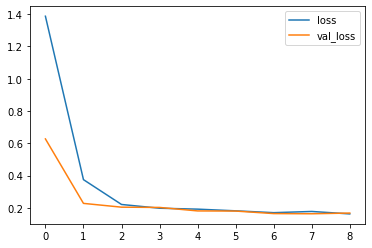

In [17]:
history = pd.DataFrame(model.history.history)
history[["loss", "val_loss"]].plot()

In [18]:
model.evaluate(test_image_gen)

11/11 [==============================] - 10s 866ms/step - loss: 0.1677 - accuracy: 0.9412


[0.1677381843328476, 0.9411538243293762]

In [21]:
pred = model.predict(test_image_gen)

In [22]:
prediction = pred > 0.5

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(test_image_gen.classes, prediction))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1300
           1       0.92      0.96      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [25]:
print(confusion_matrix(test_image_gen.classes , prediction))

[[1195  105]
 [  54 1246]]


In [43]:
from tensorflow.keras.preprocessing import image
my_image = image.load_img(un_cell, target_size = image_shape)

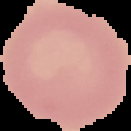

In [44]:
my_image

In [45]:
my_img_arr = image.img_to_array(my_image)

In [46]:
my_img_arr.shape

(131, 131, 3)

In [47]:
my_img_arr = np.expand_dims(my_img_arr, axis = 0)

In [48]:
my_img_arr.shape

(1, 131, 131, 3)

In [49]:
model.predict(my_img_arr)

array([[0.98456687]], dtype=float32)